_Lambda School Data Science — Applied Modeling_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Gradient Boosting


#### Objectives
- Do feature engineering with relational data
- Use xgboost for gradient boosting

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — slower than other libraries, but [the new version may be better](https://twitter.com/amuellerml/status/1129443826945396737)
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — can accept missing values and use [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html) without preprocessing
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

### Get data


#### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


#### Option 2. Kaggle API

Follow these [instructions](https://github.com/Kaggle/kaggle-api).

#### Option 3. GitHub Repo — LOCAL

If you are working locally:

1. Clone the [GitHub repo](https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling/tree/master/data/caterpillar) locally. The data is in the repo, so you don't need to download it separately.

2. Unzip the file `caterpillar-tube-pricing.zip` which is in the data folder of your local repo.

3. Unzip the file `data.zip`. 

4. Run the cell below to assign a constant named `SOURCE`, a string that points to the location of the data on your local machine. The rest of the code in the notebook will use this constant.

In [1]:
SOURCE = '../data/caterpillar/caterpillar-tube-pricing/competition_data/'

#### Option 4. GitHub Repo — COLAB

If you are working on Google Colab, uncomment and run these cells, to download the data, unzip it, and assign a constant that points to the location of the data.

In [3]:
import zipfile
import urllib.request

url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip'
fname = 'caterpillar-tube-pricing.zip'

urllib.request.urlretrieve(url, fname)

('caterpillar-tube-pricing.zip', <http.client.HTTPMessage at 0x285ebba0cc0>)

In [4]:
with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [1]:
SOURCE = 'competition_data'

In [2]:
import os

os.path.join(SOURCE, 'bill_of_materials.csv')

'competition_data\\bill_of_materials.csv'

## Do feature engineering with relational data

Here are some questions — not answers!

### `bill_of_materials`

is formatted like this:

In [3]:
import pandas as pd
materials = pd.read_csv(os.path.join(SOURCE, 'bill_of_materials.csv'))
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Would this be a better representation?

Could pandas melt, crosstab, and other functions help reshape the data like this?

| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

### `components`

Contains three representations of each component, in order of decreasing cardinality / granularity:

- `component_id`
- `name`
- `component_type_id`

What are the pros & cons of these different representations?

In [4]:
components = pd.read_csv(os.path.join(SOURCE, 'components.csv'))
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-0186,FLANGE,OTHER
freq,1,350,1006


In [5]:
components.head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


### Tip/trick: Want to read all the files at once?

In [6]:
from glob import glob

data = {}
for path in glob(os.path.join(SOURCE, '*.csv')):
    df = pd.read_csv(path)
    filename = path.split('/')[-1]
    name = filename.split('.')[0]
    data[name] = df

## Example solution for last assignment 🚜

In [ ]:
# !pip install category_encoders

In [7]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv(os.path.join(SOURCE, 'tube.csv'))
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv(os.path.join(SOURCE, 'bill_of_materials.csv'))
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv(os.path.join(SOURCE, 'components.csv'))
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv(os.path.join(SOURCE, 'specs.csv'))
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


# Read data
trainval = pd.read_csv(os.path.join(SOURCE, 'train_set.csv'))
test = pd.read_csv(os.path.join(SOURCE, 'test_set.csv'))

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [8]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv(os.path.join(SOURCE, '../sample_submission.csv'))
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-02.csv')

Validation Error 0.29767924455052


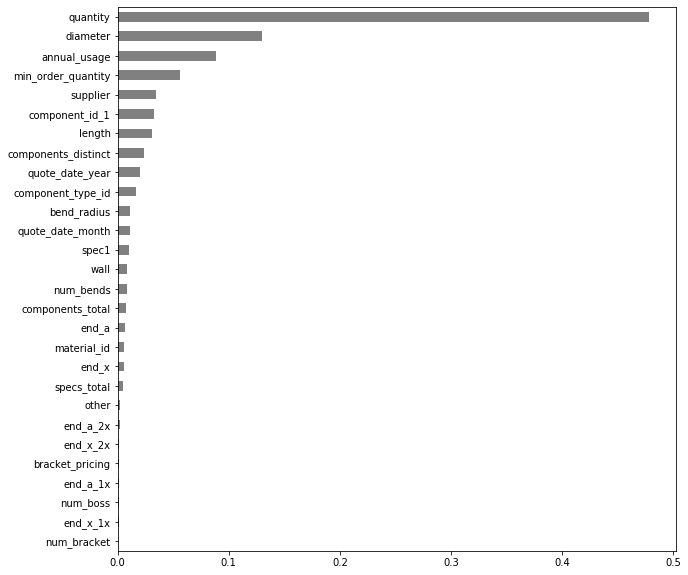

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Use xgboost for gradient boosting

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [12]:
!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/5e/49/b95c037b717b4ceadc76b6e164603471225c27052d1611d5a2e832757945/xgboost-0.90-py2.py3-none-win_amd64.whl


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:43:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.2700581596577784


In [19]:
generate_submission(pipeline, X_test, 'submission_xgboost_1000.csv')

#### Jason Brownlee, [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

In [21]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [22]:
eval_set = [
    (X_train_encoded, y_train_log),
    (X_val_encoded, y_val_log)
]

In [23]:
model = XGBRegressor(n_estimators=1000, n_jobs=-1)

model.fit(X_train_encoded,
         y_train_log,
         eval_set = eval_set,
         eval_metric='rmse',
         early_stopping_rounds=25
         )



[17:50:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 25 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.2943
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831
[7]	validation_0-rmse:0.927626	validation_1-rmse:0.922043
[8]	validation_0-rmse:0.859915	validation_1-rmse:0.857021


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[9]	validation_0-rmse:0.79993	validation_1-rmse:0.798434
[10]	validation_0-rmse:0.747476	validation_1-rmse:0.747741
[11]	validation_0-rmse:0.700332	validation_1-rmse:0.700594
[12]	validation_0-rmse:0.660556	validation_1-rmse:0.662626
[13]	validation_0-rmse:0.623149	validation_1-rmse:0.625613
[14]	validation_0-rmse:0.592345	validation_1-rmse:0.5964
[15]	validation_0-rmse:0.563782	validation_1-rmse:0.568364
[16]	validation_0-rmse:0.540559	validation_1-rmse:0.546318
[17]	validation_0-rmse:0.519686	validation_1-rmse:0.5262
[18]	validation_0-rmse:0.501662	validation_1-rmse:0.509163
[19]	validation_0-rmse:0.483726	validation_1-rmse:0.492813
[20]	validation_0-rmse:0.469637	validation_1-rmse:0.478782
[21]	validation_0-rmse:0.457696	validation_1-rmse:0.468263
[22]	validation_0-rmse:0.447907	validation_1-rmse:0.458799
[23]	validation_0-rmse:0.438943	validation_1-rmse:0.449799
[24]	validation_0-rmse:0.429626	validation_1-rmse:0.440613
[25]	validation_0-rmse:0.422943	validation_1-rmse:0.434739
[26

[148]	validation_0-rmse:0.288105	validation_1-rmse:0.317679
[149]	validation_0-rmse:0.287502	validation_1-rmse:0.317112
[150]	validation_0-rmse:0.287182	validation_1-rmse:0.316784
[151]	validation_0-rmse:0.286462	validation_1-rmse:0.316538
[152]	validation_0-rmse:0.28613	validation_1-rmse:0.316384
[153]	validation_0-rmse:0.286008	validation_1-rmse:0.316327
[154]	validation_0-rmse:0.285846	validation_1-rmse:0.316294
[155]	validation_0-rmse:0.28535	validation_1-rmse:0.315859
[156]	validation_0-rmse:0.284829	validation_1-rmse:0.315371
[157]	validation_0-rmse:0.284417	validation_1-rmse:0.315119
[158]	validation_0-rmse:0.284118	validation_1-rmse:0.314943
[159]	validation_0-rmse:0.284032	validation_1-rmse:0.315052
[160]	validation_0-rmse:0.283669	validation_1-rmse:0.314693
[161]	validation_0-rmse:0.283571	validation_1-rmse:0.314717
[162]	validation_0-rmse:0.283152	validation_1-rmse:0.314402
[163]	validation_0-rmse:0.282744	validation_1-rmse:0.314153
[164]	validation_0-rmse:0.282473	validatio

[285]	validation_0-rmse:0.255853	validation_1-rmse:0.296097
[286]	validation_0-rmse:0.255584	validation_1-rmse:0.295978
[287]	validation_0-rmse:0.255389	validation_1-rmse:0.295726
[288]	validation_0-rmse:0.255236	validation_1-rmse:0.295606
[289]	validation_0-rmse:0.255167	validation_1-rmse:0.295544
[290]	validation_0-rmse:0.255083	validation_1-rmse:0.295559
[291]	validation_0-rmse:0.254841	validation_1-rmse:0.295394
[292]	validation_0-rmse:0.254599	validation_1-rmse:0.295295
[293]	validation_0-rmse:0.25445	validation_1-rmse:0.295233
[294]	validation_0-rmse:0.254323	validation_1-rmse:0.295215
[295]	validation_0-rmse:0.254256	validation_1-rmse:0.295223
[296]	validation_0-rmse:0.254213	validation_1-rmse:0.295232
[297]	validation_0-rmse:0.253984	validation_1-rmse:0.295128
[298]	validation_0-rmse:0.253805	validation_1-rmse:0.295053
[299]	validation_0-rmse:0.253379	validation_1-rmse:0.294639
[300]	validation_0-rmse:0.253304	validation_1-rmse:0.294594
[301]	validation_0-rmse:0.253236	validati

[423]	validation_0-rmse:0.237182	validation_1-rmse:0.284557
[424]	validation_0-rmse:0.23712	validation_1-rmse:0.284635
[425]	validation_0-rmse:0.237018	validation_1-rmse:0.28438
[426]	validation_0-rmse:0.236973	validation_1-rmse:0.284378
[427]	validation_0-rmse:0.23687	validation_1-rmse:0.284241
[428]	validation_0-rmse:0.236786	validation_1-rmse:0.284248
[429]	validation_0-rmse:0.23669	validation_1-rmse:0.2841
[430]	validation_0-rmse:0.2366	validation_1-rmse:0.284094
[431]	validation_0-rmse:0.236474	validation_1-rmse:0.284047
[432]	validation_0-rmse:0.236363	validation_1-rmse:0.284029
[433]	validation_0-rmse:0.236292	validation_1-rmse:0.28404
[434]	validation_0-rmse:0.236198	validation_1-rmse:0.284043
[435]	validation_0-rmse:0.236095	validation_1-rmse:0.283892
[436]	validation_0-rmse:0.235941	validation_1-rmse:0.283642
[437]	validation_0-rmse:0.235811	validation_1-rmse:0.283671
[438]	validation_0-rmse:0.235689	validation_1-rmse:0.283581
[439]	validation_0-rmse:0.235543	validation_1-rms

[561]	validation_0-rmse:0.223796	validation_1-rmse:0.279164
[562]	validation_0-rmse:0.223727	validation_1-rmse:0.2791
[563]	validation_0-rmse:0.22367	validation_1-rmse:0.279108
[564]	validation_0-rmse:0.223643	validation_1-rmse:0.279081
[565]	validation_0-rmse:0.223635	validation_1-rmse:0.279083
[566]	validation_0-rmse:0.223614	validation_1-rmse:0.279074
[567]	validation_0-rmse:0.223603	validation_1-rmse:0.279047
[568]	validation_0-rmse:0.22359	validation_1-rmse:0.279057
[569]	validation_0-rmse:0.223554	validation_1-rmse:0.279013
[570]	validation_0-rmse:0.223531	validation_1-rmse:0.279013
[571]	validation_0-rmse:0.223448	validation_1-rmse:0.278864
[572]	validation_0-rmse:0.223373	validation_1-rmse:0.278778
[573]	validation_0-rmse:0.223288	validation_1-rmse:0.278769
[574]	validation_0-rmse:0.223227	validation_1-rmse:0.278717
[575]	validation_0-rmse:0.223205	validation_1-rmse:0.278711
[576]	validation_0-rmse:0.223128	validation_1-rmse:0.278733
[577]	validation_0-rmse:0.222938	validation_

[698]	validation_0-rmse:0.21416	validation_1-rmse:0.275506
[699]	validation_0-rmse:0.214039	validation_1-rmse:0.27544
[700]	validation_0-rmse:0.213914	validation_1-rmse:0.275327
[701]	validation_0-rmse:0.213873	validation_1-rmse:0.275323
[702]	validation_0-rmse:0.2138	validation_1-rmse:0.27532
[703]	validation_0-rmse:0.213649	validation_1-rmse:0.275224
[704]	validation_0-rmse:0.213552	validation_1-rmse:0.275128
[705]	validation_0-rmse:0.213527	validation_1-rmse:0.275115
[706]	validation_0-rmse:0.213474	validation_1-rmse:0.275109
[707]	validation_0-rmse:0.213423	validation_1-rmse:0.275189
[708]	validation_0-rmse:0.213406	validation_1-rmse:0.275178
[709]	validation_0-rmse:0.213398	validation_1-rmse:0.275168
[710]	validation_0-rmse:0.213315	validation_1-rmse:0.275065
[711]	validation_0-rmse:0.213156	validation_1-rmse:0.275061
[712]	validation_0-rmse:0.213111	validation_1-rmse:0.275062
[713]	validation_0-rmse:0.213005	validation_1-rmse:0.275037
[714]	validation_0-rmse:0.212931	validation_1

[836]	validation_0-rmse:0.204489	validation_1-rmse:0.270868
[837]	validation_0-rmse:0.204435	validation_1-rmse:0.270893
[838]	validation_0-rmse:0.20442	validation_1-rmse:0.270895
[839]	validation_0-rmse:0.204413	validation_1-rmse:0.270907
[840]	validation_0-rmse:0.204361	validation_1-rmse:0.270868
[841]	validation_0-rmse:0.204336	validation_1-rmse:0.270866
[842]	validation_0-rmse:0.204301	validation_1-rmse:0.270839
[843]	validation_0-rmse:0.20425	validation_1-rmse:0.270826
[844]	validation_0-rmse:0.204211	validation_1-rmse:0.270778
[845]	validation_0-rmse:0.204079	validation_1-rmse:0.270708
[846]	validation_0-rmse:0.203976	validation_1-rmse:0.270765
[847]	validation_0-rmse:0.203919	validation_1-rmse:0.270825
[848]	validation_0-rmse:0.203818	validation_1-rmse:0.270865
[849]	validation_0-rmse:0.203753	validation_1-rmse:0.270849
[850]	validation_0-rmse:0.203621	validation_1-rmse:0.270643
[851]	validation_0-rmse:0.203545	validation_1-rmse:0.270611
[852]	validation_0-rmse:0.203489	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

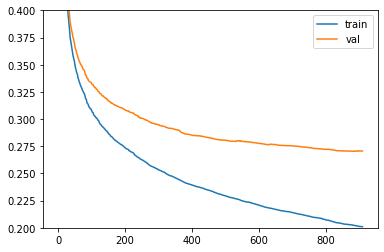

In [25]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

epochs = range(0, len(train_rmse))

plt.plot(epochs, train_rmse, label='train')
plt.plot(epochs, val_rmse, label='val')
plt.legend()
plt.ylim(0.2, 0.4);

In [27]:
!pip install catboost

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [29]:
from catboost import CatBoostRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    CatBoostRegressor(learning_rate=0.3)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

0:	learn: 1.7063512	total: 24.9ms	remaining: 24.9s
1:	learn: 1.2756902	total: 47.7ms	remaining: 23.8s
2:	learn: 0.9694022	total: 74.5ms	remaining: 24.7s
3:	learn: 0.7520570	total: 99.8ms	remaining: 24.8s
4:	learn: 0.6097303	total: 124ms	remaining: 24.7s
5:	learn: 0.5294796	total: 149ms	remaining: 24.7s
6:	learn: 0.4657627	total: 177ms	remaining: 25.1s
7:	learn: 0.4252448	total: 202ms	remaining: 25.1s
8:	learn: 0.3983808	total: 228ms	remaining: 25.1s
9:	learn: 0.3842124	total: 252ms	remaining: 24.9s
10:	learn: 0.3694200	total: 277ms	remaining: 24.9s
11:	learn: 0.3633047	total: 300ms	remaining: 24.7s
12:	learn: 0.3547063	total: 322ms	remaining: 24.5s
13:	learn: 0.3488532	total: 348ms	remaining: 24.5s
14:	learn: 0.3437360	total: 372ms	remaining: 24.4s
15:	learn: 0.3423312	total: 395ms	remaining: 24.3s
16:	learn: 0.3399380	total: 420ms	remaining: 24.3s
17:	learn: 0.3372858	total: 444ms	remaining: 24.2s
18:	learn: 0.3322560	total: 467ms	remaining: 24.1s
19:	learn: 0.3303295	total: 491ms	rem

162:	learn: 0.2424234	total: 3.88s	remaining: 19.9s
163:	learn: 0.2420430	total: 3.9s	remaining: 19.9s
164:	learn: 0.2419174	total: 3.93s	remaining: 19.9s
165:	learn: 0.2419146	total: 3.95s	remaining: 19.8s
166:	learn: 0.2418134	total: 3.97s	remaining: 19.8s
167:	learn: 0.2393780	total: 4s	remaining: 19.8s
168:	learn: 0.2385309	total: 4.02s	remaining: 19.8s
169:	learn: 0.2385285	total: 4.05s	remaining: 19.8s
170:	learn: 0.2385245	total: 4.07s	remaining: 19.7s
171:	learn: 0.2377194	total: 4.1s	remaining: 19.7s
172:	learn: 0.2366601	total: 4.12s	remaining: 19.7s
173:	learn: 0.2366303	total: 4.14s	remaining: 19.7s
174:	learn: 0.2365849	total: 4.17s	remaining: 19.6s
175:	learn: 0.2361720	total: 4.19s	remaining: 19.6s
176:	learn: 0.2356582	total: 4.21s	remaining: 19.6s
177:	learn: 0.2356543	total: 4.24s	remaining: 19.6s
178:	learn: 0.2356503	total: 4.27s	remaining: 19.6s
179:	learn: 0.2356497	total: 4.29s	remaining: 19.5s
180:	learn: 0.2356492	total: 4.32s	remaining: 19.5s
181:	learn: 0.235

323:	learn: 0.2228163	total: 7.75s	remaining: 16.2s
324:	learn: 0.2228159	total: 7.77s	remaining: 16.1s
325:	learn: 0.2228133	total: 7.79s	remaining: 16.1s
326:	learn: 0.2226969	total: 7.82s	remaining: 16.1s
327:	learn: 0.2226760	total: 7.84s	remaining: 16.1s
328:	learn: 0.2226755	total: 7.87s	remaining: 16s
329:	learn: 0.2226726	total: 7.89s	remaining: 16s
330:	learn: 0.2226722	total: 7.91s	remaining: 16s
331:	learn: 0.2226269	total: 7.94s	remaining: 16s
332:	learn: 0.2226264	total: 7.96s	remaining: 16s
333:	learn: 0.2226239	total: 7.99s	remaining: 15.9s
334:	learn: 0.2225093	total: 8.01s	remaining: 15.9s
335:	learn: 0.2224568	total: 8.03s	remaining: 15.9s
336:	learn: 0.2224523	total: 8.05s	remaining: 15.8s
337:	learn: 0.2224484	total: 8.08s	remaining: 15.8s
338:	learn: 0.2218081	total: 8.1s	remaining: 15.8s
339:	learn: 0.2218047	total: 8.13s	remaining: 15.8s
340:	learn: 0.2218045	total: 8.15s	remaining: 15.8s
341:	learn: 0.2218037	total: 8.17s	remaining: 15.7s
342:	learn: 0.2209088	t

483:	learn: 0.2102365	total: 11.6s	remaining: 12.3s
484:	learn: 0.2102362	total: 11.6s	remaining: 12.3s
485:	learn: 0.2102339	total: 11.6s	remaining: 12.3s
486:	learn: 0.2102336	total: 11.7s	remaining: 12.3s
487:	learn: 0.2102234	total: 11.7s	remaining: 12.3s
488:	learn: 0.2099300	total: 11.7s	remaining: 12.2s
489:	learn: 0.2099291	total: 11.7s	remaining: 12.2s
490:	learn: 0.2098447	total: 11.8s	remaining: 12.2s
491:	learn: 0.2098444	total: 11.8s	remaining: 12.2s
492:	learn: 0.2097907	total: 11.8s	remaining: 12.2s
493:	learn: 0.2097907	total: 11.8s	remaining: 12.1s
494:	learn: 0.2095645	total: 11.9s	remaining: 12.1s
495:	learn: 0.2095642	total: 11.9s	remaining: 12.1s
496:	learn: 0.2095640	total: 11.9s	remaining: 12.1s
497:	learn: 0.2095574	total: 12s	remaining: 12.1s
498:	learn: 0.2095572	total: 12s	remaining: 12s
499:	learn: 0.2095397	total: 12s	remaining: 12s
500:	learn: 0.2095392	total: 12s	remaining: 12s
501:	learn: 0.2095385	total: 12.1s	remaining: 12s
502:	learn: 0.2095381	total:

650:	learn: 0.2034569	total: 15.8s	remaining: 8.47s
651:	learn: 0.2034567	total: 15.8s	remaining: 8.45s
652:	learn: 0.2034559	total: 15.8s	remaining: 8.42s
653:	learn: 0.2034557	total: 15.9s	remaining: 8.4s
654:	learn: 0.2034546	total: 15.9s	remaining: 8.38s
655:	learn: 0.2032397	total: 15.9s	remaining: 8.35s
656:	learn: 0.2031996	total: 15.9s	remaining: 8.33s
657:	learn: 0.2031991	total: 16s	remaining: 8.3s
658:	learn: 0.2031979	total: 16s	remaining: 8.28s
659:	learn: 0.2031978	total: 16s	remaining: 8.25s
660:	learn: 0.2031976	total: 16s	remaining: 8.23s
661:	learn: 0.2031323	total: 16.1s	remaining: 8.2s
662:	learn: 0.2031322	total: 16.1s	remaining: 8.18s
663:	learn: 0.2031320	total: 16.1s	remaining: 8.15s
664:	learn: 0.2031316	total: 16.1s	remaining: 8.13s
665:	learn: 0.2031284	total: 16.2s	remaining: 8.11s
666:	learn: 0.2031282	total: 16.2s	remaining: 8.08s
667:	learn: 0.2031277	total: 16.2s	remaining: 8.06s
668:	learn: 0.2031274	total: 16.2s	remaining: 8.03s
669:	learn: 0.2028842	t

809:	learn: 0.2001905	total: 19.6s	remaining: 4.6s
810:	learn: 0.2001904	total: 19.6s	remaining: 4.58s
811:	learn: 0.2001903	total: 19.7s	remaining: 4.55s
812:	learn: 0.2001898	total: 19.7s	remaining: 4.53s
813:	learn: 0.2001895	total: 19.7s	remaining: 4.5s
814:	learn: 0.2001894	total: 19.7s	remaining: 4.48s
815:	learn: 0.2001893	total: 19.8s	remaining: 4.46s
816:	learn: 0.2001892	total: 19.8s	remaining: 4.43s
817:	learn: 0.2001892	total: 19.8s	remaining: 4.41s
818:	learn: 0.2001891	total: 19.8s	remaining: 4.38s
819:	learn: 0.2001890	total: 19.9s	remaining: 4.36s
820:	learn: 0.2001872	total: 19.9s	remaining: 4.33s
821:	learn: 0.2001701	total: 19.9s	remaining: 4.31s
822:	learn: 0.2001643	total: 19.9s	remaining: 4.29s
823:	learn: 0.2001621	total: 19.9s	remaining: 4.26s
824:	learn: 0.2001451	total: 20s	remaining: 4.24s
825:	learn: 0.2001394	total: 20s	remaining: 4.21s
826:	learn: 0.2001323	total: 20s	remaining: 4.19s
827:	learn: 0.2001322	total: 20s	remaining: 4.16s
828:	learn: 0.2001310	

974:	learn: 0.1946656	total: 23.6s	remaining: 606ms
975:	learn: 0.1946223	total: 23.7s	remaining: 582ms
976:	learn: 0.1946066	total: 23.7s	remaining: 558ms
977:	learn: 0.1946065	total: 23.7s	remaining: 534ms
978:	learn: 0.1946056	total: 23.8s	remaining: 510ms
979:	learn: 0.1946054	total: 23.8s	remaining: 486ms
980:	learn: 0.1946053	total: 23.8s	remaining: 461ms
981:	learn: 0.1946044	total: 23.9s	remaining: 437ms
982:	learn: 0.1946043	total: 23.9s	remaining: 413ms
983:	learn: 0.1946042	total: 23.9s	remaining: 389ms
984:	learn: 0.1946039	total: 23.9s	remaining: 364ms
985:	learn: 0.1946038	total: 24s	remaining: 340ms
986:	learn: 0.1945031	total: 24s	remaining: 316ms
987:	learn: 0.1945019	total: 24s	remaining: 292ms
988:	learn: 0.1945018	total: 24s	remaining: 267ms
989:	learn: 0.1944645	total: 24.1s	remaining: 243ms
990:	learn: 0.1944634	total: 24.1s	remaining: 219ms
991:	learn: 0.1944629	total: 24.1s	remaining: 194ms
992:	learn: 0.1944624	total: 24.1s	remaining: 170ms
993:	learn: 0.194462

In [31]:
!pip install lightgbm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [33]:
import lightgbm as lgbm

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    lgbm.sklearn.LGBMRegressor(learning_rate=0.2)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

Validation Error 0.2672733716988669


In [34]:
generate_submission(pipeline, X_test, 'submission_lgbm_lr02.csv')

#### Kaggle RMSLE: 0.29454

### Understand the difference between boosting & bagging

Boosting (used by Gradient Boosting) is different than Bagging (used by Random Forests). 

[_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.

>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**

>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.

>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**

>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

# Assignment
- Continue to participate in the [Kaggle Caterpillar competition](https://www.kaggle.com/c/caterpillar-tube-pricing).
- Do more feature engineering. 
- Use xgboost for gradient boosting.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineerng and visualization.
- Look at the bonus notebook in the repo, about Monotonic Constraints with Gradient Boosting.
- Read more about gradient boosting:
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - [Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (3 minute video)